<a href="https://colab.research.google.com/github/zhaoxin1124ds/NLP-on-scientific-articles-for-information-retrieval/blob/main/NLP_Scientific_Articles_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NLP on scientific articles for information retrieval

##Introduction
Researchers usually have access to large online archives of scientific articles. However, due to the huge number of scientific articles, finding relevant articles has become a tedious and time-consuming task. 

This experiment will work on language modeling to provide a way of giving a token of identification to research articles which facilitates recommendation and search process. 

Key work on this experiment is **word embedding**. I will test several wording embedding methods such as TF-IDF and word2vec. And then, I will evaluate the classification modeling performance on vectors from different word embedding. The best word embedding should be able to reasonably separate the articles and give out the best classification prediction. I will use the best word embedding method to realize information retrieval and produce a web **APP** for [Scientific-articles-search](https://scientific-articles-search.anvil.app/).

The data is from [Kaggle](https://www.kaggle.com/vetrirah/janatahack-independence-day-2020-ml-hackathon) and contains abstract and title for a set of scientific papers. All the papers have been labeled according to 6 topics: computer science, physics, mathematics, statistics, quantitative biology, and quantitative finance.  

##Outline
1. Data loading and EDA
2. Data pre-processing
3. Word embedding and classification

  3.1 TF-IDF

  3.2 Classification using vectors from TF-IDF

  3.3 word2vec

  3.4 Classification using vecotrs from word2vec

4. Information retrieval
5. Discussion

##1. Data loading and EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
url = 'https://drive.google.com/file/d/1nUGw8eV74RcwqgE-yVy3jOo-4xi3V2aJ/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.read_csv(path)

In [ ]:
data.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,6,On maximizing the fundamental frequency of the...,Let $\Omega \subset \mathbb{R}^n$ be a bound...,0,0,1,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15928 entries, 0 to 15927
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    15928 non-null  int64 
 1   TITLE                 15928 non-null  object
 2   ABSTRACT              15928 non-null  object
 3   Computer Science      15928 non-null  int64 
 4   Physics               15928 non-null  int64 
 5   Mathematics           15928 non-null  int64 
 6   Statistics            15928 non-null  int64 
 7   Quantitative Biology  15928 non-null  int64 
 8   Quantitative Finance  15928 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.1+ MB


In [ ]:
col_list = data.columns
print(col_list)

Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')


In [ ]:
print(data.loc[421,'TITLE'])
print(data.loc[421,'ABSTRACT'])

Anisotropic exchange and spin-wave damping in pure and electron-doped Sr$_2$IrO$_4$
  The collective magnetic excitations in the spin-orbit Mott insulator
(Sr$_{1-x}$La$_x$)$_2$IrO$_4$ ($x=0,\,0.01,\,0.04,\, 0.1$) were investigated by
means of resonant inelastic x-ray scattering. We report significant magnon
energy gaps at both the crystallographic and antiferromagnetic zone centers at
all doping levels, along with a remarkably pronounced momentum-dependent
lifetime broadening. The spin-wave gap is accounted for by a significant
anisotropy in the interactions between $J_\text{eff}=1/2$ isospins, thus
marking the departure of Sr$_2$IrO$_4$ from the essentially isotropic
Heisenberg model appropriate for the superconducting cuprates.



In [ ]:
for col in col_list[3:]:
  print("The number of {} articles is: {}.".format(col, data[col].value_counts().iloc[1]))

The number of Computer Science articles is: 4910.
The number of Physics articles is: 5120.
The number of Mathematics articles is: 3610.
The number of Statistics articles is: 1636.
The number of Quantitative Biology articles is: 443.
The number of Quantitative Finance articles is: 209.


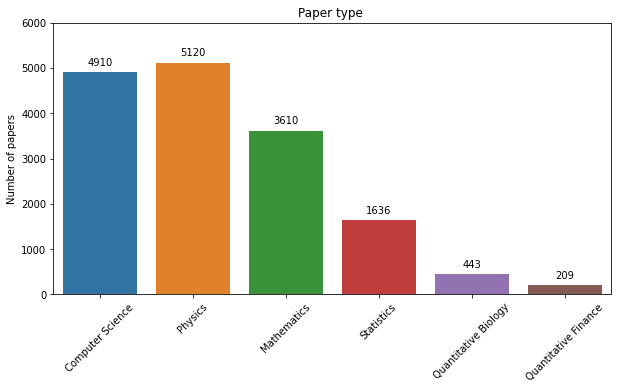

In [ ]:
fig = plt.figure(figsize=(10,5)) 
splot = sns.barplot(x=col_list[3:], y=data.iloc[:,3:].sum().values)
plt.ylabel('Number of papers')
plt.ylim(0,6000)
plt.title('Paper type ')
plt.xticks(rotation=45)
for p in splot.patches:
  splot.annotate(format(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

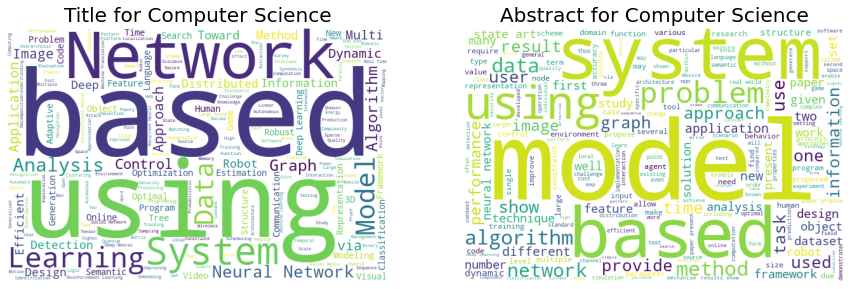

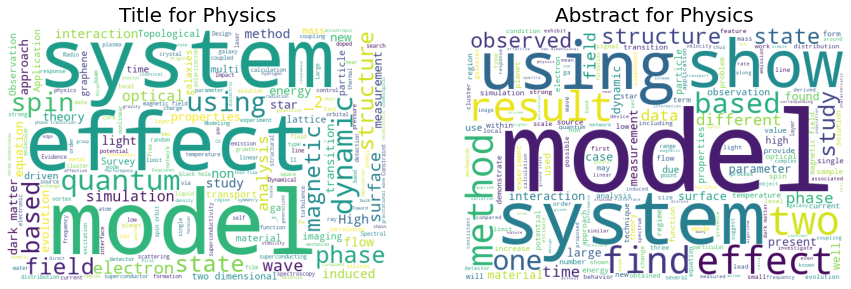

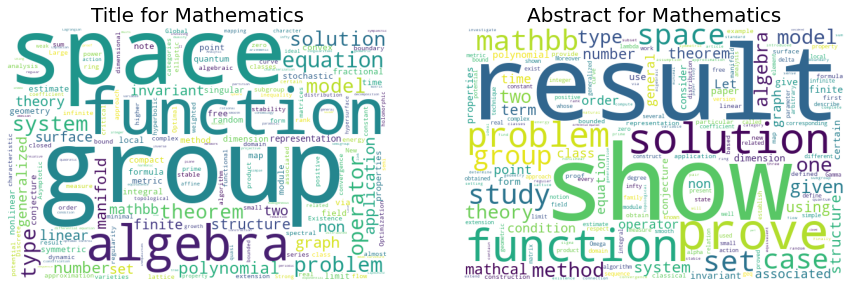

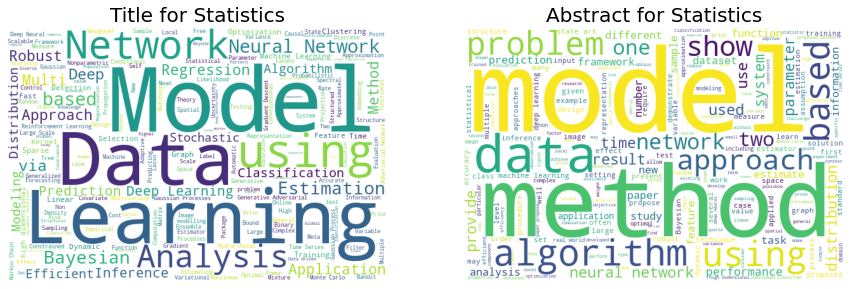

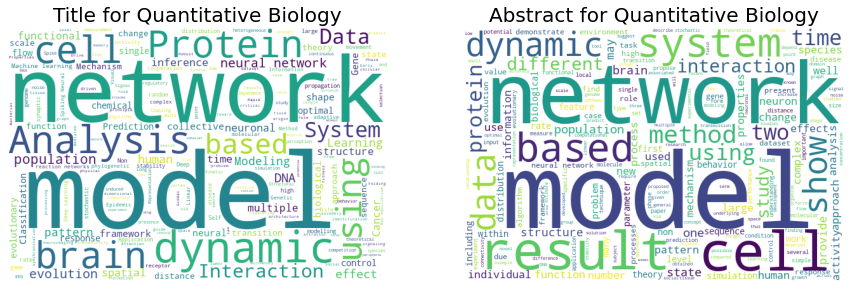

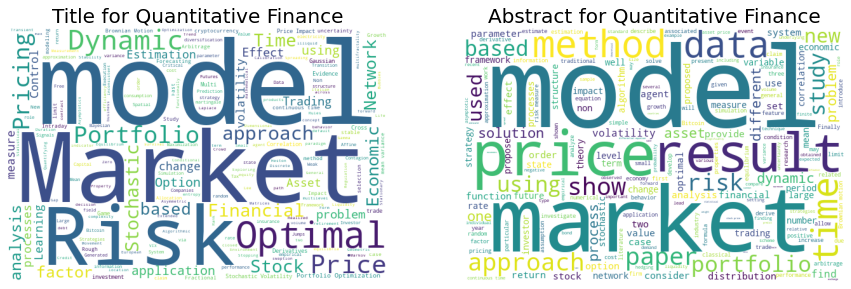

In [ ]:
from wordcloud import WordCloud

for col in col_list[3:]:

  title_words = data[data[col]==1]['TITLE']
  abstr_words = data[data[col]==1]['ABSTRACT']

  fig = plt.figure(figsize=(15,5))  
  
  plt.subplot(1,2,1)
  title_cloud = WordCloud(background_color='white',
                          width=600,
                          height=400).generate(" ".join(title_words))
  plt.imshow(title_cloud)
  plt.axis('off')
  plt.title('Title for {}'.format(col),fontsize=20);

  plt.subplot(1,2,2)
  abstr_cloud = WordCloud(background_color='white',
                          width=600,
                          height=400).generate(" ".join(abstr_words))
  plt.imshow(abstr_cloud)
  plt.axis('off')
  plt.title('Abstract for {}'.format(col),fontsize=20);

plt.show()

##Observations:

We can see that the most frequent words in the title and abstract are overall identical. So the strategy for word embedding will be on a simple connection between title and abstract, i.e. input for word embedding = title + abstract.

##2. Data pre-processing

Data pre-processing inculdes:
1. removing numbers and any words with numbers
2. removing new line
3. removing punctuations
4. removing extra white spaces

In [ ]:
import nltk
import re
import spacy
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
# define a clean flow 
import string
def clean_text(text):
    text = text.lower() ###lower case
    text = re.sub('\n', ' ', text) ### remove new line sign
    text = re.sub('\r', ' ', text) 
    text = re.sub('\t', ' ', text) ### remove tab sign
    text = re.sub(r'(\b|\s+\-?|^\-?)(\d+|\d*\.\d+)\b', ' ', text) ### hand the positive and negative number, but does not affect character+number
    text = re.sub('\w*\d\w*', '', text) ### remove words containing numbers, also remove pure numners
    text = re.sub('[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n]', ' ', text) ### replace characters in list as space, not touch apostrophe for stop words such as don't, won't, etc.
    text = re.sub(r'\\', ' ', text) ### replace \\
    text = re.sub(r'\s+', ' ', text) ###replace whitespaces
    text = text.strip() ### reomove leading and tailing whitespace

    return text

In [ ]:
data_clean = pd.DataFrame()
data_clean['TITLE'] = data['TITLE'].apply(clean_text)
data_clean['ABSTRACT'] = data['ABSTRACT'].apply(clean_text)

In [ ]:
nlp = spacy.load("en")

In [ ]:
data_token = data_clean.copy()

In [ ]:
for i, text in enumerate(data_token['TEXT']):
  data_token.loc[i,'lemma'] = ['nan']
  data_token.loc[i, 'lemma'] = [token.lemma_ for token in nlp(text) if not token.is_punct and not token.is_stop and len(token)>1]
  data_token.loc[i, 'sent'] = " ".join([token.lemma_ for token in nlp(text) if not token.is_punct and not token.is_stop and len(token)>1])

In [ ]:
data_token['ID'] = data['ID']
for col in col_list[3:]:
  data_token[col] = data[col]

In [ ]:
url = 'https://drive.google.com/file/d/1ueUaNVni36zXVOn7cLbNDkdR4GDHVRmf/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data_token = pd.read_csv(path)
data_token.head()

,ID,TITLE,ABSTRACT,TEXT,lemma,sent,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,reconstructing subject specific effect maps,predictive models allow subject specific infer...,reconstructing subject specific effect maps pr...,"['reconstruct', 'subject', 'specific', 'effect...",reconstruct subject specific effect map predic...,1,0,0,0,0,0
1,2,rotation invariance neural network,rotation invariance and translation invariance...,rotation invariance neural network rotation in...,"['rotation', 'invariance', 'neural', 'network'...",rotation invariance neural network rotation in...,1,0,0,0,0,0
2,3,spherical polyharmonics and poisson kernels fo...,we introduce and develop the notion of spheric...,spherical polyharmonics and poisson kernels fo...,"['spherical', 'polyharmonic', 'poisson', 'kern...",spherical polyharmonic poisson kernel polyharm...,0,0,1,0,0,0
3,4,a finite element approximation for the stochas...,the stochastic landau lifshitz gilbert llg equ...,a finite element approximation for the stochas...,"['finite', 'element', 'approximation', 'stocha...",finite element approximation stochastic maxwel...,0,0,1,0,0,0
4,6,on maximizing the fundamental frequency of the...,let omega subset mathbb r n be a bounded domai...,on maximizing the fundamental frequency of the...,"['maximize', 'fundamental', 'frequency', 'comp...",maximize fundamental frequency complement obst...,0,0,1,0,0,0


##3. Word embedding and classification

Word embedding approaches:
1. TF-IDF
2. word2vec

Classification using supervised learning methods:
1. LogisticRegression

***Please note here that due to the huge size of the corpus, both word embedding and modeling training take a long time to finish and the notebook is very easy to crash due to memory issues. So I just put the most optimized word embedding approaches here. And since LogisticRegression gives reasonable results, I will not provide more classification approach here also due to the memory issue.

###3.1 TF-IDF

In [ ]:
from sklearn.preprocessing import LabelEncoder

col_list = ['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']

data_token['TOPIC'] = data_token[col_list].values.tolist()

le = LabelEncoder()
data_token['TOPIC'] = le.fit_transform(data_token['TOPIC'].astype(str))

data_token.head(10)

,ID,TITLE,ABSTRACT,TEXT,lemma,sent,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,TOPIC
0,1,reconstructing subject specific effect maps,predictive models allow subject specific infer...,reconstructing subject specific effect maps pr...,"['reconstruct', 'subject', 'specific', 'effect...",reconstruct subject specific effect map predic...,1,0,0,0,0,0,5
1,2,rotation invariance neural network,rotation invariance and translation invariance...,rotation invariance neural network rotation in...,"['rotation', 'invariance', 'neural', 'network'...",rotation invariance neural network rotation in...,1,0,0,0,0,0,5
2,3,spherical polyharmonics and poisson kernels fo...,we introduce and develop the notion of spheric...,spherical polyharmonics and poisson kernels fo...,"['spherical', 'polyharmonic', 'poisson', 'kern...",spherical polyharmonic poisson kernel polyharm...,0,0,1,0,0,0,3
3,4,a finite element approximation for the stochas...,the stochastic landau lifshitz gilbert llg equ...,a finite element approximation for the stochas...,"['finite', 'element', 'approximation', 'stocha...",finite element approximation stochastic maxwel...,0,0,1,0,0,0,3
4,6,on maximizing the fundamental frequency of the...,let omega subset mathbb r n be a bounded domai...,on maximizing the fundamental frequency of the...,"['maximize', 'fundamental', 'frequency', 'comp...",maximize fundamental frequency complement obst...,0,0,1,0,0,0,3
5,7,on the rotation period and shape of the hyperb...,we observed the newly discovered hyperbolic mi...,on the rotation period and shape of the hyperb...,"['rotation', 'period', 'shape', 'hyperbolic', ...",rotation period shape hyperbolic asteroid oumu...,0,1,0,0,0,0,4
6,8,adverse effects of polymer coating on heat tra...,the ability of metallic nanoparticles to suppl...,adverse effects of polymer coating on heat tra...,"['adverse', 'effect', 'polymer', 'coat', 'heat...",adverse effect polymer coat heat transport sol...,0,1,0,0,0,0,4
7,9,sph calculations of mars scale collisions the ...,we model large scale approx impacts on a mars ...,sph calculations of mars scale collisions the ...,"['sph', 'calculation', 'mars', 'scale', 'colli...",sph calculation mars scale collision role equa...,0,1,0,0,0,0,4
8,10,mathcal r fails to predict the outbreak potent...,time varying susceptibility of host at individ...,mathcal r fails to predict the outbreak potent...,"['mathcal', 'fail', 'predict', 'outbreak', 'po...",mathcal fail predict outbreak potential presen...,0,0,0,0,1,0,1
9,11,a global sensitivity analysis and reduced orde...,we present a systematic global sensitivity ana...,a global sensitivity analysis and reduced orde...,"['global', 'sensitivity', 'analysis', 'reduce'...",global sensitivity analysis reduce order model...,1,0,0,0,0,0,5


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_inp_list = []

for text in (data_token['sent']):
  tfidf_inp_list.append(text)

print(len(tfidf_inp_list))
print(tfidf_inp_list[0])
print(tfidf_inp_list[-1])
print(type(tfidf_inp_list[-1]))

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.3, min_df=10,  norm=u'l2', smooth_idf=True, ngram_range=(1,2))
 
X = vectorizer.fit_transform(tfidf_inp_list)

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
data_tfidf = pd.concat([data_token[['TOPIC', 'sent']], tfidf_df], axis=1)
data_tfidf.head()

###3.2 Classification on vectors from TF-IDF

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
y = data_tfidf['TOPIC']
X = data_tfidf.drop(columns=['TOPIC','sent'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=41)

In [ ]:
### Logistic regression
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)
print("\nmodel {} fitting score:".format('LogisticRegression'))
print('Training set score:', clf.score(X_train, y_train))
print('Training set score:', clf.score(X_test, y_test))


model LogisticRegression fitting score:
Training set score: 0.9185851820845542
Training set score: 0.84353421217828


###3.3 word2vec

In [ ]:
import gensim

In [ ]:
inp_list = []

for text in (data_token['sent']):
  inp_list.append(text.split())

print(len(inp_list))
print(inp_list[0:2])

15928
[['reconstruct', 'subject', 'specific', 'effect', 'map', 'predictive', 'model', 'allow', 'subject', 'specific', 'inference', 'analyze', 'disease', 'relate', 'alteration', 'neuroimage', 'datum', 'give', 'subject', 'data', 'inference', 'level', 'global', 'identifiye', 'condition', 'presence', 'subject', 'local', 'detect', 'condition', 'effect', 'individual', 'measurement', 'extract', 'subject', 'datum', 'global', 'inference', 'widely', 'local', 'inference', 'form', 'subject', 'specific', 'effect', 'map', 'rarely', 'exist', 'model', 'yield', 'noisy', 'detection', 'compose', 'disperse', 'isolate', 'island', 'article', 'propose', 'reconstruction', 'method', 'name', 'rsm', 'improve', 'subject', 'specific', 'detection', 'predictive', 'modeling', 'approach', 'particular', 'binary', 'classifier', 'rsm', 'specifically', 'aim', 'reduce', 'noise', 'sampling', 'error', 'associate', 'finite', 'sample', 'example', 'train', 'classifier', 'propose', 'method', 'wrapper', 'type', 'algorithm', 'diff

In [ ]:
model = gensim.models.Word2Vec(inp_list, workers=8, min_count=1, window=6, sg=0, hs=1, size=300)

In [ ]:
word2vec = np.zeros((data_token.shape[0],300)) ### an array of N x 300

In [ ]:
for i, text in enumerate(inp_list):
  word2vec[i,:] = np.mean([model[lemma] for lemma in text], axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
word2vec_df = pd.DataFrame(word2vec)
word2vec_df = pd.concat([data_token['TOPIC'], data[['TITLE', 'ABSTRACT']], word2vec_df], axis=1)
word2vec_df.head()

,TOPIC,TITLE,ABSTRACT,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,Computer Science,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,0.296722,0.152602,0.258326,0.042392,-0.033997,-0.019464,0.159040,0.085443,0.085328,0.299818,0.048129,0.023367,0.125954,-0.242886,-0.243925,0.223496,-0.092886,0.272294,0.100847,-0.319434,0.067188,-0.045630,-0.206637,-0.070222,-0.295883,-0.134036,-0.214221,-0.115921,-0.003651,0.131354,-0.361298,0.030927,-0.266193,0.128717,-0.169924,-0.084625,-0.084161,...,-0.133844,-0.262785,0.041200,-0.224503,0.067261,-0.059653,-0.337558,0.200436,-0.059990,0.074992,0.155776,-0.215029,0.011076,-0.110285,0.061372,-0.107713,-0.112344,-0.173914,-0.082454,-0.167176,0.088023,-0.107752,0.024700,0.416176,0.245705,-0.286022,0.007118,0.074942,-0.135018,-0.022346,-0.155123,0.043742,-0.114632,0.040489,-0.017922,0.374488,-0.140367,-0.081736,-0.012803,0.020227
1,Computer Science,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,0.093535,-0.443809,0.145511,0.406224,0.281378,-0.033659,0.363411,-0.114502,0.275362,0.438893,-0.047197,0.147225,0.130209,-0.464664,-0.040920,0.190189,-0.177283,-0.185296,0.008726,-0.001238,0.243035,-0.061084,0.023098,0.305636,-0.203745,-0.029970,-0.128883,-0.072133,0.012936,0.232098,-0.265999,0.004616,-0.152539,-0.388218,-0.396621,0.034014,-0.236007,...,-0.061385,-0.293908,0.200098,0.082971,0.424171,0.375347,-0.240401,0.040380,-0.064659,-0.126098,-0.083825,-0.040259,-0.071431,-0.019486,0.395144,-0.155333,-0.076021,-0.095398,0.175365,-0.160179,-0.022818,0.021489,0.052283,0.393304,-0.022616,0.206619,0.100987,0.063055,-0.071486,0.149691,-0.130510,-0.086181,-0.226469,0.443262,-0.204712,0.479603,0.363920,-0.300666,0.348191,0.037843
2,Mathematics,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0.171726,-0.350208,-0.119351,0.101042,-0.052356,0.131555,0.088461,-0.356224,0.015114,0.190878,-0.051439,-0.107905,-0.028777,0.246717,0.039664,-0.323876,0.176802,0.324356,0.159586,0.128345,-0.169781,-0.219181,0.045816,-0.306355,-0.262608,-0.155393,-0.149988,-0.161691,-0.165707,-0.227843,-0.070937,-0.080520,-0.094894,0.128059,-0.202371,-0.316836,-0.056789,...,-0.243895,-0.480440,-0.073855,0.338395,0.206128,-0.099940,-0.604384,-0.041087,-0.099649,-0.228528,0.200025,-0.055713,0.068880,0.296477,-0.088702,-0.067467,-0.014897,0.180715,0.204529,0.191916,0.162610,-0.140045,-0.045198,-0.009524,-0.415985,0.214561,0.265038,0.218490,-0.119971,0.127069,-0.149006,-0.270164,0.323063,0.087374,0.484995,-0.091111,0.203558,-0.185614,-0.038023,-0.288224
3,Mathematics,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0.230514,-0.221137,0.086471,0.131568,-0.119475,0.223842,-0.034174,-0.049969,0.044146,0.089437,-0.081393,-0.095493,0.284772,-0.141665,0.042348,-0.042428,0.225021,0.687485,0.025505,0.027526,-0.103015,-0.247524,0.134353,-0.175356,-0.122075,-0.218913,-0.139744,-0.143452,0.051620,-0.241980,-0.031238,-0.419059,-0.100569,0.172230,0.081593,-0.356269,-0.417090,...,-0.236135,-0.450048,-0.138928,-0.199092,0.050550,-0.269194,-0.309927,0.023300,-0.099738,-0.049181,-0.049345,-0.032566,0.061512,-0.044420,0.019645,-0.116566,-0.027813,-0.160276,-0.165990,-0.001626,-0.016321,-0.096195,0.148217,0.053182,-0.248702,0.452424,0.141513,0.418804,0.085381,0.061046,-0.546650,-0.080136,0.162588,0.000062,-0.107461,0.000760,0.512998,-0.400774,-0.078269,-0.226176
4,Mathematics,On maximizing the fundamental frequency of the...,Let $\Omega \subset \mathbb{R}^n$ be a bound...,0.151770,-0.116637,-0.349956,-0.043620,-0.174396,0.631757,0.152761,-0.127318,-0.189233,0.113730,-0.236836,-0.066643,0.312067,-0.055980,-0.130168,-0.264538,-0.423862,0.257566,-0.072122,-0.208357,-0.51728

In [ ]:
word2vec_df.dropna(inplace=True)
word2vec_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15928 entries, 0 to 15927
Columns: 303 entries, TOPIC to 299
dtypes: float64(300), object(3)
memory usage: 36.9+ MB


In [ ]:
y = word2vec_df['TOPIC']
X = word2vec_df.drop(columns=['TOPIC','TITLE', 'ABSTRACT'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

###3.4 Classification on vectord from word2vec

In [ ]:
### Logistic regression
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)
print("\nmodel {} fitting score:".format('Logistic Regression'))
print('Training set score:', clf.score(X_train, y_train))
print('Test set score:', clf.score(X_test, y_test))


model Logistic Regression fitting score:
Training set score: 0.8662690315492073
Test set score: 0.8443188951663528


##Observations:

The modeling performance is overall comparable between vectors from TF-IDF and word2vec while the one for TF-IDF looks a little bit overfitting. So I will use the model from word2vec for information retrieval.


##4. information retrieval

Information retrieval process includes:
1. vectorization of keywords of input for information retrieval
2. vector similarity evaluation using cosine-similarity
3. front-end web APP

In [ ]:
def get_embedding_w2v1(token): ### to vectorize the query using trained model, query is a string

  embedding = [] ### a list to store the vector of query

  if len(token)<1: ### if query length smaller than 1 than output a vector of 0s
    return np.zeros(300)
  else:
    for tok in (token): ### for each word in the query, if it is in the vocabulary of the model, transfer it to vector
      if tok in model.wv.vocab:
        embedding.append(model[tok]) 
      else: ### if it is not in the vocabulary, give it a random value.
        embedding.append(np.random.rand(300))

  return np.mean(embedding, axis=0) ### mean value of all the words to get the vector of the query, this is same with 
                                    ### what we did when generating vectors for data base.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
#topic_list = ['Quantitative Biology', 'Quantitative Finance', 'Mathematics','Physics', 'Computer Science', 'Statistics']
#for i,topic in enumerate(word2vec_df['TOPIC']):
  #word2vec_df.loc[i, 'TOPIC'] = topic_list[int(topic)-1]

doc_vec = word2vec_df.drop(columns=['TOPIC','TITLE','ABSTRACT'])

In [ ]:
def info_retrv(inp_string): ### information retrieval, input must be a list of string ['string1', 'string2', ..., 'stringn']

  inp_string_cln = clean_text(inp_string)
  query_vec = get_embedding_w2v1(inp_string.split())

  doc = word2vec_df[['TOPIC','TITLE','ABSTRACT']]
  doc['similarity'] = 0

  for i in range(word2vec_df.shape[0]):
  
    doc.loc[i, 'similarity'] = cosine_similarity(np.array(doc_vec.loc[i,:]).reshape(1,-1), np.array(query_vec).reshape(1,-1)).item()

  doc.sort_values(by='similarity', ascending=False, inplace=True)
  doc = doc.iloc[:5].reset_index(drop=True)

  return doc.head()


In [ ]:
info_retrv('monte carlo')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


,TOPIC,TITLE,ABSTRACT,similarity
0,Physics,Backward Monte-Carlo applied to muon transport,We discuss a backward Monte-Carlo technique ...,0.896824
1,Quantitative Finance,Finite Sample Complexity of Sequential Monte C...,We present bounds for the finite sample erro...,0.724756
2,Quantitative Finance,The application of Monte Carlo methods for lea...,Monte Carlo method is a broad class of compu...,0.709787
3,Quantitative Finance,Unbiased and Consistent Nested Sampling via Se...,We introduce a new class of sequential Monte...,0.709406
4,Quantitative Finance,Stability of Conditional Sequential Monte Carlo,The particle Gibbs (PG) sampler is a Markov ...,0.693957


##Observation:

The algorithm of information retrieval gives reasonable top 5 search results. The next step is to integrate this searching engine into a web APP.

Anvil provides the interaction tools connecting a web app to a Colab notebook, below the link please see the notebook implementing the information retrieval algorithm to the APP of "scientific articles search".
https://colab.research.google.com/drive/1YMpL_Y7BDCXIPEWTtBjO1Ie2usmSqlNo?usp=sharing

##5. Discussions

We notice that the data is not perfectly balanced. Articles on Quantitative Biology and Quantitative Finance are much less than the others. That will cause some inaccuracy in information retrieval. Expanding the database will definitely improve the performance of word embedding. On the other hand, although we observe the overall identical word frequency between the title and abstract, the title should provide the best expression for the article still. Playing with the weight between the title and the abstract may also help to improve the information retrieval.

In [ ]:
import umap

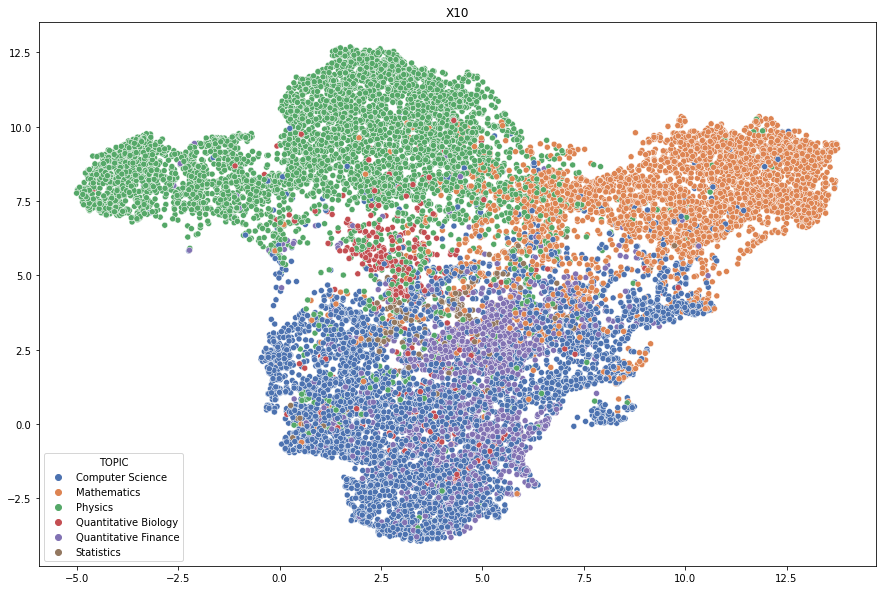

In [ ]:
plt.figure(figsize=(15,10))
X_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', random_state=42).fit_transform(X)
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y, palette="deep")

plt.show()

Here we have a 2D plot for all 6 topics/clusters. The first observation is that there is no clear boundary to separate all 6 clusters. This could be related to the complex features of the documents. However, we may still get some interesting observations: 1. computer science, mathematics, and physics are overall separated from each other. 2. quantitative finance, quantitative biology, and statistics are quite close to computer science, I think that is because the three topics implemented a lot of concepts and techniques of computer science.